
# Lab 2: Sentiment Analysis with a Multi Layer Perceptron using Keras

__Objective__: We'll repeat the experiments in Lab 1, but in this case we'll extend the model adding new layers. In addition we will review some of the regularization techniques seen in class. The objectives for the lab session are the following:

- Learn adding layers in Keras.
- Experiment using different number of hidden layers with different hidden units.
- Experiment with regularization techniques such as early-stoping, reducing the model, weight regularization and drop-out.


## 1. Loading the data
We'll use the same data used in previous session. You need to follow the same steps specified in lab1.

In [1]:
# Mount Drive files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# install libraries
!pip install tensorflow
!pip install datasets==2.17.1
# import load_dataset from dataset
from datasets import load_dataset
## for replicability of results
import numpy as np
import pandas as pd
import tensorflow as tf
tf.keras.utils.set_random_seed(2)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2023.10.0 which is incompatible.


In [3]:
# custom data loader path CHANGE home TO YOUR DIRECTORY
home = '/content/drive/MyDrive/Colab Notebooks/dl4nlp_summer_labs/'
sst_home = home + 'utils/sst_custom_loader.py'
# load data with load_dataset and our custom data loader script
data = load_dataset(sst_home)
training_set = pd.DataFrame(data['train'])
dev_set = pd.DataFrame(data['validation'])
test_set = pd.DataFrame(data['test'])

print('Training size: {}'.format(len(training_set)))
print('Dev size: {}'.format(len(dev_set)))
print('Test size: {}'.format(len(test_set)))

/usr/local/lib/python3.12/dist-packages/datasets/load.py:923: FutureWarning: The repository for sst_custom_loader contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at /content/drive/MyDrive/Colab Notebooks/dl4nlp_summer_labs/utils/sst_custom_loader.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Training size: 6920
Dev size: 872
Test size: 1821


## 2. Preprocessing and vectorization

In [4]:
from tensorflow.keras.preprocessing import text
from sklearn.utils import shuffle

# Shuffle dataset
training_set = shuffle(training_set)
dev_set = shuffle(dev_set)

test_set = shuffle(test_set)

# Obtain text and label vectors, and tokenize the text
train_texts = training_set.text
train_labels = training_set.label

dev_texts = dev_set.text
dev_labels = dev_set.label

test_texts = test_set.text
test_labels = test_set.label

# Create a tokenize that takes the 1000 most common words
tokenizer = text.Tokenizer(num_words=1000)

# Build the word index (dictionary)
tokenizer.fit_on_texts(train_texts) # Create word index using only training part

# Vectorize texts into one-hot encoding representations
x_train = tokenizer.texts_to_matrix(train_texts, mode='binary')
x_dev = tokenizer.texts_to_matrix(dev_texts, mode='binary')
x_test = tokenizer.texts_to_matrix(test_texts, mode='binary')

y_train = train_labels
y_dev = dev_labels
y_test = test_labels

print('Shape of the training set (nb_examples, vector_size): {}'.format(x_train.shape))
print('Shape of the validation set (nb_examples, vector_size): {}'.format(x_dev.shape))
print('Shape of the test set (nb_examples, vector_size): {}'.format(x_test.shape))

Shape of the training set (nb_examples, vector_size): (6920, 1000)
Shape of the validation set (nb_examples, vector_size): (872, 1000)
Shape of the test set (nb_examples, vector_size): (1821, 1000)


## 3. Building the model
Based on previous code we'll extend the model to a Multi Layer Perceptron with one hidden units. For that we'll make use of a fully connected (```Dense```) layers with a ```relu``` activation. In this case the hidden layer will have 16 hidden units (feel free to explore different dimensionality of hidden units).

Remenber that applying ```Dense``` layer with ```relu``` activation we are implementing the following tensor operation:

```
output = relu(dot(W, input) + b)
```
### Exercise 1
Answer the following questions:
- What does having 16 hidden units mean? What the size of matrix ```W```?

__Answer__: Means that our dense layer output shape is 16, so the W size is a matrix of 1000 X 16 (input_size X output_size)

-----

Increasing the number of hidden units we are allowing the network to learn more complex representations, but at the same time we are making the network more computationally expensive and may lead to overfit the training data.

Regarding the architecture, there are three main decisions that we need to take:
- The number of layers
- The number of hidden units for each layers
- Activation function of the layers

The code below implements a fully connected archicteture with only one intermediate layer and an output layer that predicts the sentiment of the input review.

>>>>>>>![](http://ixa2.si.ehu.es/~jibloleo/uc3m_dl4nlp/img/Two_layers_NN.png)

In [5]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense

input_size = x_train[0].shape[0] ## vector length equals to vocabulary size.

# Define the model
model = Sequential()
model.add(Input(shape=(input_size,)))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
# Note that we do not need to indicate the input shape for the sucessives layes

# Compile the model using a loss function and an optimizer.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │        16,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,033 (62.63 KB)

 Trainable params: 16,033 (62.63 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
tf.keras.utils.set_random_seed(2)
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_dev, y_dev), verbose=2)

Epoch 1/100
217/217 - 6s - 28ms/step - accuracy: 0.6308 - loss: 0.6499 - val_accuracy: 0.7167 - val_loss: 0.5784
Epoch 2/100
217/217 - 1s - 2ms/step - accuracy: 0.7568 - loss: 0.5274 - val_accuracy: 0.7557 - val_loss: 0.5099
Epoch 3/100
217/217 - 1s - 3ms/step - accuracy: 0.7880 - loss: 0.4636 - val_accuracy: 0.7592 - val_loss: 0.4979
Epoch 4/100
217/217 - 1s - 2ms/step - accuracy: 0.8022 - loss: 0.4333 - val_accuracy: 0.7580 - val_loss: 0.5015
Epoch 5/100
217/217 - 1s - 2ms/step - accuracy: 0.8064 - loss: 0.4150 - val_accuracy: 0.7511 - val_loss: 0.5094
Epoch 6/100
217/217 - 1s - 2ms/step - accuracy: 0.8116 - loss: 0.4021 - val_accuracy: 0.7523 - val_loss: 0.5182
Epoch 7/100
217/217 - 1s - 2ms/step - accuracy: 0.8163 - loss: 0.3921 - val_accuracy: 0.7511 - val_loss: 0.5271
Epoch 8/100
217/217 - 1s - 2ms/step - accuracy: 0.8210 - loss: 0.3836 - val_accuracy: 0.7511 - val_loss: 0.5356
Epoch 9/100
217/217 - 1s - 3ms/step - accuracy: 0.8236 - loss: 0.3760 - val_accuracy: 0.7500 - val_loss

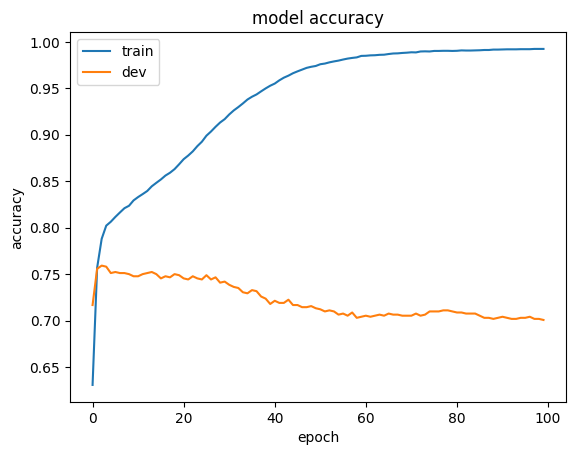

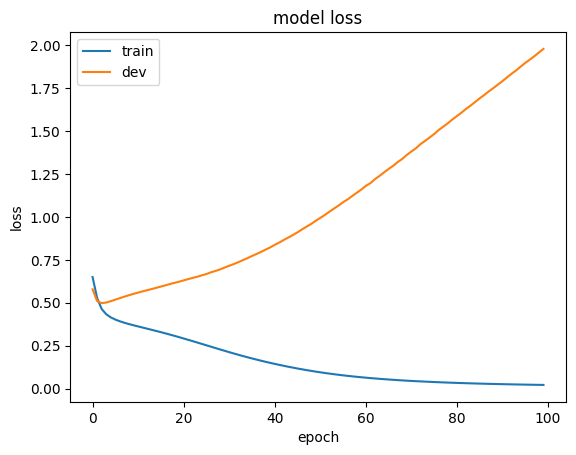

In [7]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

### Exercise 2
Plots shows that model ends up overfitting the training data. One way to prevent overfitting is to stop training once accuracy in the validation set starts decreasing.
- Could you retrain the model from the scratch for only four epochs?

- Optionally, Keras provides early stopping mechanism as callback object(https://keras.io/callbacks/#earlystopping) that could be used when fiting the model:

```
from tensorflow.keras.callbacks import EarlyStopping
...
early_stop = EarlyStopping(monitor='val_accuracy', patience=1)
...
history_exercise = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_dev, y_dev), verbose=2, callbacks=[early_stop])

```

Epoch 1/100
217/217 - 3s - 12ms/step - accuracy: 0.6308 - loss: 0.6499 - val_accuracy: 0.7167 - val_loss: 0.5784
Epoch 2/100
217/217 - 1s - 4ms/step - accuracy: 0.7568 - loss: 0.5274 - val_accuracy: 0.7557 - val_loss: 0.5099
Epoch 3/100
217/217 - 1s - 4ms/step - accuracy: 0.7880 - loss: 0.4636 - val_accuracy: 0.7592 - val_loss: 0.4979
Epoch 4/100
217/217 - 1s - 4ms/step - accuracy: 0.8022 - loss: 0.4333 - val_accuracy: 0.7580 - val_loss: 0.5015


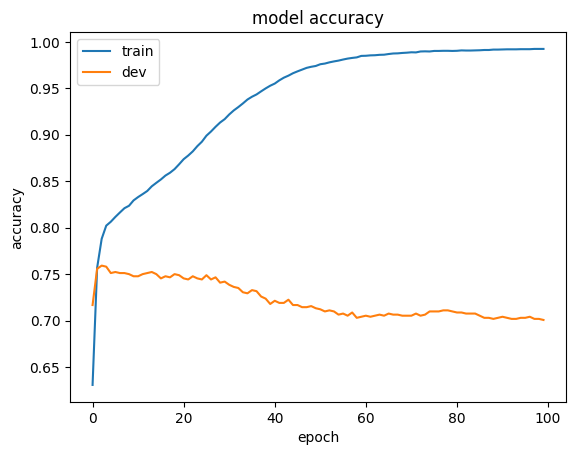

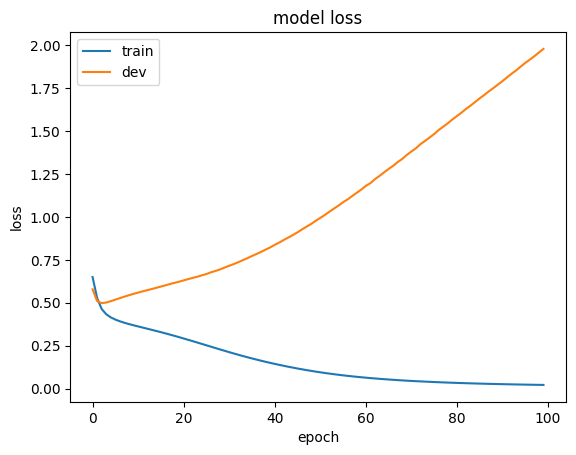

In [8]:
### TODO: copy the code above and adapt to complete the exercise
from tensorflow.keras.callbacks import EarlyStopping
tf.keras.utils.set_random_seed(2)
model = Sequential()
model.add(Input(shape=(input_size,)))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_accuracy', patience=1)
history_exer = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_dev, y_dev), verbose=2, callbacks=[early_stop])

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

---
- Optionally you can try different activations (e.g ```tanh```, ```sigmoid```) instead of ```relu```.
- Or try different loss function like mean_squared_error (```mse```).

---

## 3.1 Adding new layers
In this section we will extend the model by adding new fully connected layer. By adding new layers we are increasing the capacity of the model we are not reducing the overfitting, but for the moment  we do not care about this.

### Exercise 3
- The code below defines a model with two hidden layers,  add a third intermediate layer with 16 hidden units and ```relu``` activation.

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 16)             │        16,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,577 (64.75 KB)

 Trainable params: 16,577 (64.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
217/217 - 3s - 16ms/step - accuracy: 0.6038 - loss: 0.6504 - val_accuracy: 0.7420 - val_loss: 0.5448
Epoch 2/20
217/217 - 1s - 3ms/step - accuracy: 0.7678 - loss: 0.4826 - val_accuracy: 0.7534 - val_loss: 0.5178
Epoch 3/20
217/217 - 1s - 3ms/step - accuracy: 0.8149 - loss: 0.4101 - val_accuracy: 0.7431 - val_loss: 0.5377
Epoch 4/20
217/217 - 1s - 3ms/step - accuracy: 0.8439 - loss: 0.3616 - val_accuracy: 0.7511 - val_loss: 0.5682
Epoch 5/20
217/217 - 1s - 3ms/step - accuracy: 0.8697 - loss: 0.3134 - val_accuracy: 0.7431 - val_loss: 0.6182
Epoch 6/20
217/217 - 1s - 4ms/step - accuracy: 0.8961 - loss: 0.2630 - val_accuracy: 0.7431 - val_loss: 0.6809
Epoch 7/20
217/217 - 1s - 4ms/step - accuracy: 0.9202 - loss: 0.2134 - val_accuracy: 0.7328 - val_loss: 0.7682
Epoch 8/20
217/217 - 1s - 4ms/step - accuracy: 0.9377 - loss: 0.1676 - val_accuracy: 0.7248 - val_loss: 0.8852
Epoch 9/20
217/217 - 1s - 3ms/step - accuracy: 0.9556 - loss: 0.1284 - val_accuracy: 0.7202 - val_loss: 1.0103


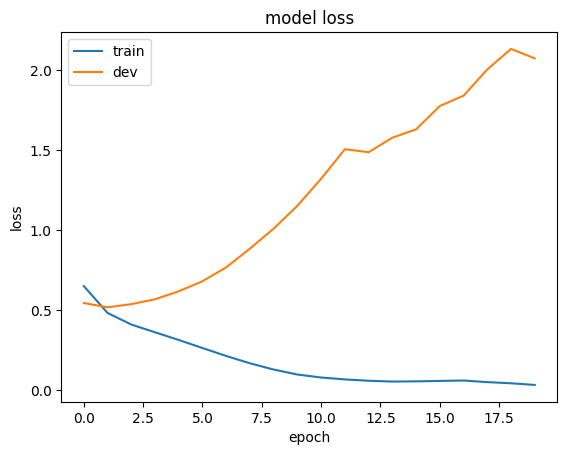

In [9]:
import matplotlib.pyplot as plt
tf.keras.utils.set_random_seed(2)

input_size = x_train[0].shape[0] ## vector length equals to vocabulary size.

# Define the model TODO: add a third intermediate layer
model = Sequential()
model.add(Input(shape=(input_size,)))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
# Note that we do not need to indicate the input shape for the sucessives layers

# Compile the model using a loss function and an optimizer.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_dev, y_dev), verbose=2)
history_orig = history

# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

## 4. Regularization techniques

We will apply the following ones:
- Reducing the network size
- Adding weight regularization
- Adding dropout

### 4.1 Reducing the network size
One way to prevent overfitting is to reduce the size of the model. As we know the size of the model is measured with the number of parameters that we need to learn. Remenber that the number of parameters are determined by the number of layers and the number of units per layer.



### Exercise 4
Run the following cell of code and try to answer the following question:
- Can you describe the relation of training and validation loss curves when traning with less parameters?

__Answer__: We reduce overfitting by reducing model size. Smaller models have less capacity to learn.

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 4)              │         4,004 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,029 (15.74 KB)

 Trainable params: 4,029 (15.74 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
217/217 - 3s - 15ms/step - accuracy: 0.5712 - loss: 0.6728 - val_accuracy: 0.6491 - val_loss: 0.6320
Epoch 2/20
217/217 - 1s - 3ms/step - accuracy: 0.7247 - loss: 0.5779 - val_accuracy: 0.7523 - val_loss: 0.5337
Epoch 3/20
217/217 - 1s - 2ms/step - accuracy: 0.7793 - loss: 0.4868 - val_accuracy: 0.7546 - val_loss: 0.5012
Epoch 4/20
217/217 - 1s - 3ms/step - accuracy: 0.7984 - loss: 0.4432 - val_accuracy: 0.7569 - val_loss: 0.5012
Epoch 5/20
217/217 - 1s - 3ms/step - accuracy: 0.8084 - loss: 0.4201 - val_accuracy: 0.7511 - val_loss: 0.5092
Epoch 6/20
217/217 - 1s - 3ms/step - accuracy: 0.8150 - loss: 0.4050 - val_accuracy: 0.7489 - val_loss: 0.5198
Epoch 7/20
217/217 - 1s - 4ms/step - accuracy: 0.8199 - loss: 0.3933 - val_accuracy: 0.7500 - val_loss: 0.5297
Epoch 8/20
217/217 - 1s - 4ms/step - accuracy: 0.8247 - loss: 0.3840 - val_accuracy: 0.7557 - val_loss: 0.5401
Epoch 9/20
217/217 - 1s - 4ms/step - accuracy: 0.8302 - loss: 0.3758 - val_accuracy: 0.7500 - val_loss: 0.5519


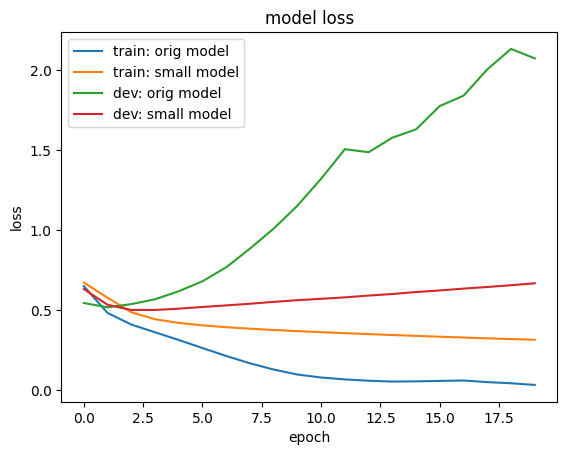

In [10]:
tf.keras.utils.set_random_seed(2)

input_size = x_train[0].shape[0] ## vector length equals to vocabulary size.

# Define the model
model = Sequential()
model.add(Input(shape=(input_size,)))
model.add(Dense(units=4, activation='relu'))
model.add(Dense(units=4, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
# Note that we do not need to indicate the input shape for the sucessives layes

# Compile the model using a loss function and an optimizer.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_dev, y_dev), verbose=2)

# summarize history for accuracy
plt.plot(history_orig.history['loss'])
plt.plot(history.history['loss'])

plt.plot(history_orig.history['val_loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train: orig model', 'train: small model', 'dev: orig model', 'dev: small model'], loc='upper left')
plt.show()

We can compare the loss of bigger model with a higher _capacity_. Note that a model with a higher number of parameters has more memorization capacity and consequently can show a poorer generalization with higher risk of overfitting to training data.

### Exercise 5
Run the following cell of code and try to answer the following question:
- Can you describe the relation of training and validation loss curves when traning with more parameters?

__Answer__: The overfitting takes fewer steps than before, dev loss increases faster

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 512)            │       512,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 775,681 (2.96 MB)

 Trainable params: 775,681 (2.96 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
217/217 - 3s - 16ms/step - accuracy: 0.6993 - loss: 0.5712 - val_accuracy: 0.7534 - val_loss: 0.5090
Epoch 2/20
217/217 - 1s - 3ms/step - accuracy: 0.8438 - loss: 0.3512 - val_accuracy: 0.7374 - val_loss: 0.6001
Epoch 3/20
217/217 - 1s - 4ms/step - accuracy: 0.9364 - loss: 0.1579 - val_accuracy: 0.7534 - val_loss: 0.8316
Epoch 4/20
217/217 - 1s - 4ms/step - accuracy: 0.9724 - loss: 0.0706 - val_accuracy: 0.7351 - val_loss: 1.0750
Epoch 5/20
217/217 - 1s - 4ms/step - accuracy: 0.9838 - loss: 0.0428 - val_accuracy: 0.7351 - val_loss: 1.1974
Epoch 6/20
217/217 - 1s - 4ms/step - accuracy: 0.9887 - loss: 0.0283 - val_accuracy: 0.7317 - val_loss: 1.3369
Epoch 7/20
217/217 - 1s - 2ms/step - accuracy: 0.9928 - loss: 0.0157 - val_accuracy: 0.7443 - val_loss: 1.4107
Epoch 8/20
217/217 - 1s - 3ms/step - accuracy: 0.9932 - loss: 0.0129 - val_accuracy: 0.7420 - val_loss: 1.4584
Epoch 9/20
217/217 - 1s - 3ms/step - accuracy: 0.9934 - loss: 0.0117 - val_accuracy: 0.7374 - val_loss: 1.5024


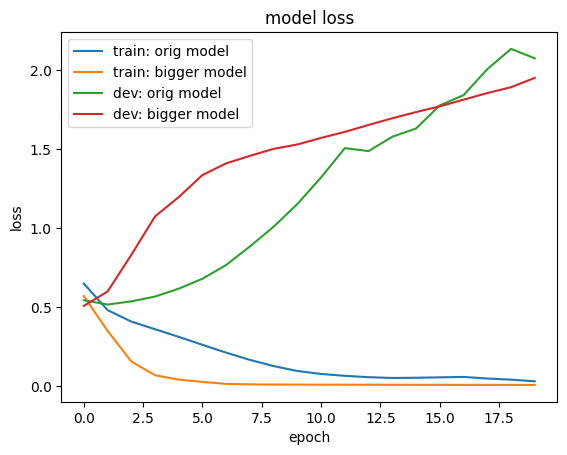

In [11]:
tf.keras.utils.set_random_seed(2)

input_size = x_train[0].shape[0] ## vector length equals to vocabulary size.

# Define the model
model = Sequential()
model.add(Input(shape=(input_size,)))
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
# Note that we do not need to indicate the input shape for the sucessives layes

# Compile the model using a loss function and an optimizer.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_dev, y_dev), verbose=2)

# summarize history for accuracy
plt.plot(history_orig.history['loss'])
plt.plot(history.history['loss'])

plt.plot(history_orig.history['val_loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train: orig model', 'train: bigger model', 'dev: orig model', 'dev: bigger model'], loc='upper left')
plt.show()

-----

### 4.2 Adding weight regularization

Another common way to try avoiding overfitting is to put constraints on the complexity of a network by forcing its weights to only take small values, which makes the distribution of weight values more "regular". This is called _weight regularization_, and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

- __L1 regularization__, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

- __L2 regularization__, where the cost added is proportional to the square of the value of the weights coefficients.

In Keras, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. In this case, we'll use the L2 norm to regularize the weights of the model.

Epoch 1/20
217/217 - 5s - 22ms/step - accuracy: 0.6272 - loss: 0.6784 - val_accuracy: 0.7626 - val_loss: 0.5806
Epoch 2/20
217/217 - 2s - 8ms/step - accuracy: 0.7558 - loss: 0.5368 - val_accuracy: 0.7592 - val_loss: 0.5408
Epoch 3/20
217/217 - 1s - 3ms/step - accuracy: 0.7876 - loss: 0.4909 - val_accuracy: 0.7511 - val_loss: 0.5512
Epoch 4/20
217/217 - 1s - 3ms/step - accuracy: 0.8000 - loss: 0.4723 - val_accuracy: 0.7477 - val_loss: 0.5632
Epoch 5/20
217/217 - 1s - 3ms/step - accuracy: 0.8084 - loss: 0.4573 - val_accuracy: 0.7454 - val_loss: 0.5769
Epoch 6/20
217/217 - 1s - 3ms/step - accuracy: 0.8189 - loss: 0.4400 - val_accuracy: 0.7351 - val_loss: 0.5927
Epoch 7/20
217/217 - 1s - 3ms/step - accuracy: 0.8342 - loss: 0.4192 - val_accuracy: 0.7374 - val_loss: 0.6150
Epoch 8/20
217/217 - 1s - 3ms/step - accuracy: 0.8494 - loss: 0.3980 - val_accuracy: 0.7362 - val_loss: 0.6388
Epoch 9/20
217/217 - 1s - 3ms/step - accuracy: 0.8679 - loss: 0.3743 - val_accuracy: 0.7328 - val_loss: 0.6660


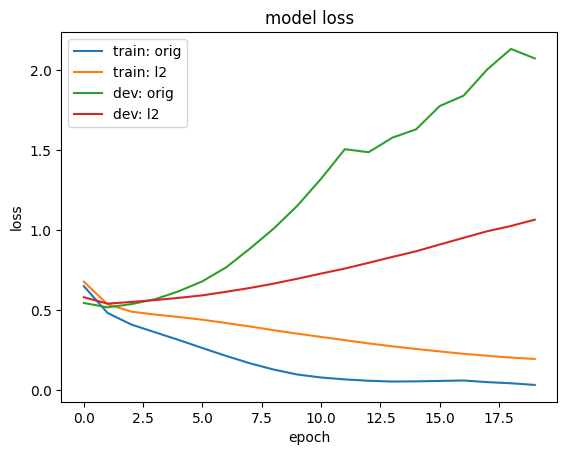

In [12]:
from tensorflow.keras import regularizers
tf.keras.utils.set_random_seed(2)

input_size = x_train[0].shape[0] ## vector length equals to vocabulary size.

# Define the model
model = Sequential()
model.add(Input(shape=(input_size,)))
model.add(Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
model.add(Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model using a loss function and an optimizer.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history_l2 = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_dev, y_dev), verbose=2)

# summarize history for accuracy
plt.plot(history_orig.history['loss'])
plt.plot(history_l2.history['loss'])

plt.plot(history_orig.history['val_loss'])
plt.plot(history_l2.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train: orig', 'train: l2', 'dev: orig', 'dev: l2'], loc='upper left')
plt.show()

### Exercise 6
- Explore different regularization weigths (e.g. 0.001, 0.01, 0.1). Do you see any difference in the learning curves?
- You can try __L1 regularization__, or both together.

```
# L1 regularization
regularizers.l1(0.001)

# L1 and L2 regularization at the same time
regularizers.l1_l2(l1=0.001, l2=0.001)
```

-----

### 4.3 Adding dropout
Another popular regularization technique for deep learning is _dropout_. It has been proven to be very successful in many cases, which state-of-the-art of the architecture can be improved around 1-2% of accuracy.

The algorithm is simple: At every training step every unit has a probability $p$ of being dropped out (it will not take into account during the evaluation step, setting it to zero).  In Keras user needs to set a _dropout rate_, which is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 16)             │        16,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,305 (63.69 KB)

 Trainable params: 16,305 (63.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
217/217 - 4s - 20ms/step - accuracy: 0.5266 - loss: 0.6887 - val_accuracy: 0.5470 - val_loss: 0.6770
Epoch 2/20
217/217 - 1s - 3ms/step - accuracy: 0.6035 - loss: 0.6576 - val_accuracy: 0.7099 - val_loss: 0.6042
Epoch 3/20
217/217 - 1s - 3ms/step - accuracy: 0.6893 - loss: 0.5985 - val_accuracy: 0.7649 - val_loss: 0.5384
Epoch 4/20
217/217 - 1s - 3ms/step - accuracy: 0.7371 - loss: 0.5393 - val_accuracy: 0.7638 - val_loss: 0.5086
Epoch 5/20
217/217 - 1s - 3ms/step - accuracy: 0.7717 - loss: 0.5000 - val_accuracy: 0.7603 - val_loss: 0.5001
Epoch 6/20
217/217 - 1s - 3ms/step - accuracy: 0.7916 - loss: 0.4564 - val_accuracy: 0.7638 - val_loss: 0.5006
Epoch 7/20
217/217 - 1s - 3ms/step - accuracy: 0.7932 - loss: 0.4528 - val_accuracy: 0.7546 - val_loss: 0.5022
Epoch 8/20
217/217 - 1s - 3ms/step - accuracy: 0.8059 - loss: 0.4251 - val_accuracy: 0.7546 - val_loss: 0.5166
Epoch 9/20
217/217 - 1s - 3ms/step - accuracy: 0.8218 - loss: 0.4037 - val_accuracy: 0.7569 - val_loss: 0.5182


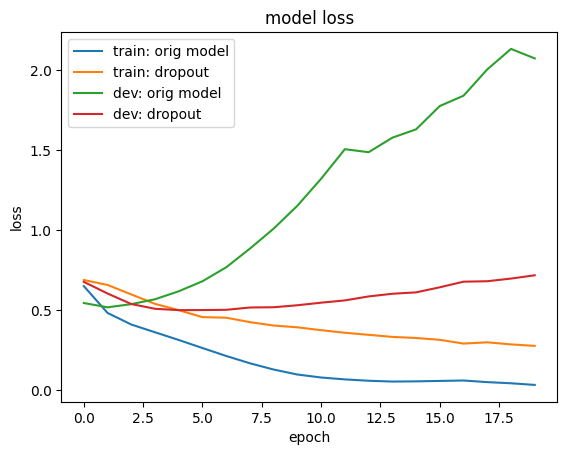

In [13]:
from tensorflow.keras.layers import Dropout
tf.keras.utils.set_random_seed(2)

input_size = x_train[0].shape[0] ## vector length equals to vocabulary size.

# Define the model
model = Sequential()
model.add(Input(shape=(input_size,)))
model.add(Dense(units=16, activation='relu'))
# we add a drop-out layer after the first fully connected layer
model.add(Dropout(0.5))

model.add(Dense(units=16, activation='relu'))
# we add a drop-out layer after the second fully connected layer
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model using a loss function and an optimizer.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_dev, y_dev), verbose=2)

# summarize history for accuracy
plt.plot(history_orig.history['loss'])
plt.plot(history.history['loss'])

plt.plot(history_orig.history['val_loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train: orig model', 'train: dropout', 'dev: orig model', 'dev: dropout'], loc='upper left')
plt.show()

### Exercise 7
- Try different dropout rates and decide which one is the best.

## Improve your model
It would be great if you could try improving the model by exploring different hyperparameters. For example,  you can explore the following ones:
- Learning Rates of the optimizer.
- Combination of different regularization techniques.
- Vocabulary size (using larger set of words).
- Number of hidden layers and size of the layers.
- Number of training epochs.


In [14]:
from tensorflow.keras import Sequential, Input, regularizers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

 # preprocess the data so that we take the whole vocabulary
 # Obtain text and label vectors, and tokenize the text
train_texts = training_set.text
train_labels = training_set.label

dev_texts = dev_set.text
dev_labels = dev_set.label

test_texts = test_set.text
test_labels = test_set.label

# Create a tokenize that takes all then words
tokenizer = text.Tokenizer(num_words=None)

# Build the word index (dictionary)
tokenizer.fit_on_texts(train_texts) # Create word index using only training part

# Vectorize texts into one-hot encoding representations
x_train = tokenizer.texts_to_matrix(train_texts, mode='binary')
x_dev = tokenizer.texts_to_matrix(dev_texts, mode='binary')
x_test = tokenizer.texts_to_matrix(test_texts, mode='binary')

y_train = train_labels
y_dev = dev_labels
y_test = test_labels

print('Shape of the training set (nb_examples, vector_size): {}'.format(x_train.shape))
print('Shape of the validation set (nb_examples, vector_size): {}'.format(x_dev.shape))
print('Shape of the test set (nb_examples, vector_size): {}'.format(x_test.shape))

Shape of the training set (nb_examples, vector_size): (6920, 13840)
Shape of the validation set (nb_examples, vector_size): (872, 13840)
Shape of the test set (nb_examples, vector_size): (1821, 13840)


In [15]:
def get_model(input_size, reg_weight = 0.0, dr=0.0):
    model = Sequential()
    model.add(Input(shape=(input_size,)))
    model.add(Dense(units=512, activation='relu',
                    kernel_regularizer=regularizers.l2(reg_weight)))
    # we add a drop-out layer after the first fully connected layer
    model.add(Dropout(dr))

    model.add(Dense(units=256, activation='relu',
                    kernel_regularizer=regularizers.l2(reg_weight)))
    model.add(Dropout(dr))

    model.add(Dense(units=128, activation='relu',
                    kernel_regularizer=regularizers.l2(reg_weight)))
    model.add(Dropout(dr))

    model.add(Dense(units=1, activation='sigmoid',
              kernel_regularizer=regularizers.l2(reg_weight)))
    return model


In [16]:
import time
tf.keras.utils.set_random_seed(2)

input_size = x_train[0].shape[0] ## vector length equals to vocabulary size.
lrs = [0.0001, 0.001, 0.01]
drs = [0.0, 0.2, 0.5]
regs = [0.0, 0.0001]
num_epochs = 100

early_stop = EarlyStopping(monitor='val_loss', patience=1)

histories = {}
for lr in lrs:
    for reg in regs:
        for dr in drs:
            # Define the model
            model = get_model(input_size, reg, dr)
            # Compile the model using a loss function and an optimizer.
            model.compile(loss='binary_crossentropy',
                          optimizer=Adam(learning_rate=lr),
                          metrics=['accuracy'])

            print('[{}]: Training model: lr{}-reg{}-dr{}'.format(time.asctime(),lr, reg, dr))
            # Train the model
            histories["lr{}-reg{}-dr{}".format(lr, reg, dr)] = model.fit(x_train, y_train, epochs=num_epochs, batch_size=32,
                                                                         validation_data=(x_dev, y_dev), verbose=2,
                                                                         callbacks=[early_stop])


[Wed Sep 24 16:43:01 2025]: Training model: lr0.0001-reg0.0-dr0.0
Epoch 1/100
217/217 - 6s - 28ms/step - accuracy: 0.6373 - loss: 0.6558 - val_accuracy: 0.7718 - val_loss: 0.5406
Epoch 2/100
217/217 - 1s - 6ms/step - accuracy: 0.8691 - loss: 0.3410 - val_accuracy: 0.7844 - val_loss: 0.4587
Epoch 3/100
217/217 - 2s - 10ms/step - accuracy: 0.9704 - loss: 0.0996 - val_accuracy: 0.7878 - val_loss: 0.5535
[Wed Sep 24 16:43:11 2025]: Training model: lr0.0001-reg0.0-dr0.2
Epoch 1/100
217/217 - 7s - 34ms/step - accuracy: 0.5853 - loss: 0.6784 - val_accuracy: 0.6755 - val_loss: 0.6320
Epoch 2/100
217/217 - 1s - 6ms/step - accuracy: 0.8105 - loss: 0.4677 - val_accuracy: 0.7764 - val_loss: 0.4467
Epoch 3/100
217/217 - 1s - 6ms/step - accuracy: 0.9353 - loss: 0.1874 - val_accuracy: 0.7764 - val_loss: 0.5027
[Wed Sep 24 16:43:22 2025]: Training model: lr0.0001-reg0.0-dr0.5
Epoch 1/100
217/217 - 7s - 34ms/step - accuracy: 0.5221 - loss: 0.6901 - val_accuracy: 0.5126 - val_loss: 0.6832
Epoch 2/100
21

In [17]:
best_epochs = []
accs = []
params_list = []
for params in histories:
    params_list.append(params)
    index = np.argmax(histories[params].history['val_accuracy'])
    best_epochs.append(index+1)
    accs.append(histories[params].history['val_accuracy'][index])
pd.DataFrame(data={'params': params_list, 'best_epoch':best_epochs, 'acc':accs})

,params,best_epoch,acc
0,lr0.0001-reg0.0-dr0.0,3,0.787844
1,lr0.0001-reg0.0-dr0.2,2,0.776376
2,lr0.0001-reg0.0-dr0.5,4,0.802752
3,lr0.0001-reg0.0001-dr0.0,2,0.792431
4,lr0.0001-reg0.0001-dr0.2,2,0.784404
5,lr0.0001-reg0.0001-dr0.5,4,0.792431
6,lr0.001-reg0.0-dr0.0,1,0.792431
7,lr0.001-reg0.0-dr0.2,2,0.792431
8,lr0.001-reg0.0-dr0.5,2,0.783257
9,lr0.001-reg0.0001-dr0.0,2,0.795872
